# Stock Prices Paths Simulation

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
plt.style.use('default')
pio.templates.default = "seaborn"

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

np.random.seed(27)

### Get Option Data

In [2]:
symbol = 'META'  # AAPL, TSLA, MSFT, META, CAT, STM, GOOG, NFLX, AMZN
dates = options.get_expiration_dates(symbol)
# print(dates)

T_str = 'June 21, 2024'  # This is the first "greater than a year" expiry date
calls = options.get_calls(symbol, T_str)
puts = options.get_puts(symbol, T_str)

T_datetime = datetime.strptime(T_str, '%B %d, %Y')
ttm = (T_datetime - datetime.now()).days / 365.0  # to use the time to maturity in float mode

calls['Time-to-maturity'] = ttm
puts['Time-to-maturity'] = ttm
# display(calls.columns)
print(calls.head())

         Contract Name         Last Trade Date  Strike  Last Price     Bid   
0  META240621C00005000   2023-07-13 1:55PM EDT     5.0      310.36    0.00  \
1  META240621C00010000   2023-02-27 3:36PM EDT    10.0      160.70  194.00   
2  META240621C00015000   2023-07-12 2:50PM EDT    15.0      292.81    0.00   
3  META240621C00020000  2023-02-28 11:10AM EDT    20.0      157.30  187.85   
4  META240621C00025000   2023-06-15 9:30AM EDT    25.0      248.78  283.20   

      Ask  Change % Change Volume Open Interest Implied Volatility   
0    0.00     0.0        -     28             0              0.00%  \
1  197.90     0.0        -      4            11              0.00%   
2    0.00     0.0        -      2             0              0.00%   
3  189.75     0.0        -      2            26              0.00%   
4  286.30     0.0        -      2            96            131.98%   

   Time-to-maturity  
0          0.928767  
1          0.928767  
2          0.928767  
3          0.928767  


#### Find historical volatility

In [3]:
# historic volatility
stock_data = si.get_data(symbol, start_date='31/05/2021', end_date='31/05/2023')
# print(stock_data.head())
stock_data['Returns'] = stock_data['close'] / stock_data['close'].shift()
stock_data['Log Returns'] = np.log(stock_data['Returns'])
print(stock_data.head())
volatility = stock_data['Log Returns'].std() * np.sqrt(252)
print(f'\n{symbol} historical volatility: {round(volatility, 3)}')

                  open        high         low       close    adjclose   
2021-06-01  330.149994  331.420013  326.640015  329.130005  329.130005  \
2021-06-02  330.380005  331.869995  327.119995  329.149994  329.149994   
2021-06-03  325.779999  327.380005  323.480011  326.040009  326.040009   
2021-06-04  325.899994  332.459991  325.179993  330.350006  330.350006   
2021-06-07  329.480011  337.690002  328.929993  336.579987  336.579987   

              volume ticker   Returns  Log Returns  
2021-06-01  11765900   META       NaN          NaN  
2021-06-02  11654300   META  1.000061     0.000061  
2021-06-03  12610800   META  0.990551    -0.009493  
2021-06-04  13289400   META  1.013219     0.013133  
2021-06-07  20136700   META  1.018859     0.018683  

META historical volatility: 0.549


### Data preparation

In [4]:
# convert the 'Implied Volatility' column to a numeric type
calls['Implied Volatility'] = pd.to_numeric(calls['Implied Volatility'].str.strip('%')) / 100
puts['Implied Volatility'] = pd.to_numeric(puts['Implied Volatility'].str.strip('%')) / 100
# choose one option as starting point
option = calls.iloc[np.random.randint(len(calls))]
print(option)

Contract Name            META240621C00100000
Last Trade Date       2023-07-14 10:46AM EDT
Strike                                 100.0
Last Price                             217.0
Bid                                      0.0
Ask                                      0.0
Change                                   0.0
% Change                                   -
Volume                                     1
Open Interest                              0
Implied Volatility                       0.0
Time-to-maturity                    0.928767
Name: 19, dtype: object


#### Fix simulation parameters

In [5]:
# FIXED PARAMETERS (used for all models)
S0 = si.get_live_price(symbol)  # get live price of stock
print(f'{symbol} Current stock price: {round(S0, 2)}')
T = ttm  # Expiry Date in years
days = 252
paths = 1000
K = option[2]  # Strike price
sigma = volatility
r = 0.0  # risk.free interest rate
q = 0
size = (days, paths)
exercise = 'european'

META Current stock price: 308.87


### Black and Scholes model

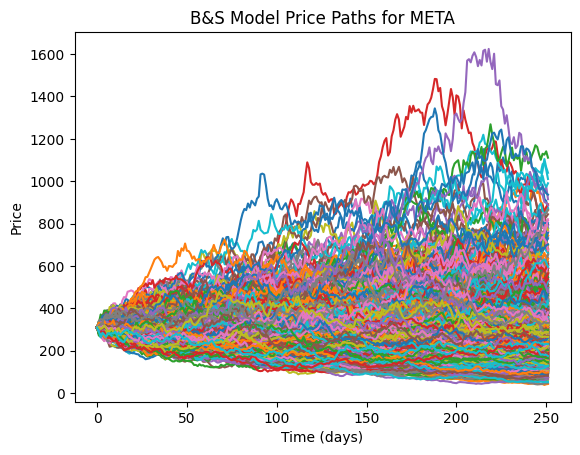

<Figure size 1000x600 with 0 Axes>

In [6]:
BS = BS_Pricer(S0, r, q, sigma, T, exercise, K)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)  # Plot all paths

#### Plot a subset of paths

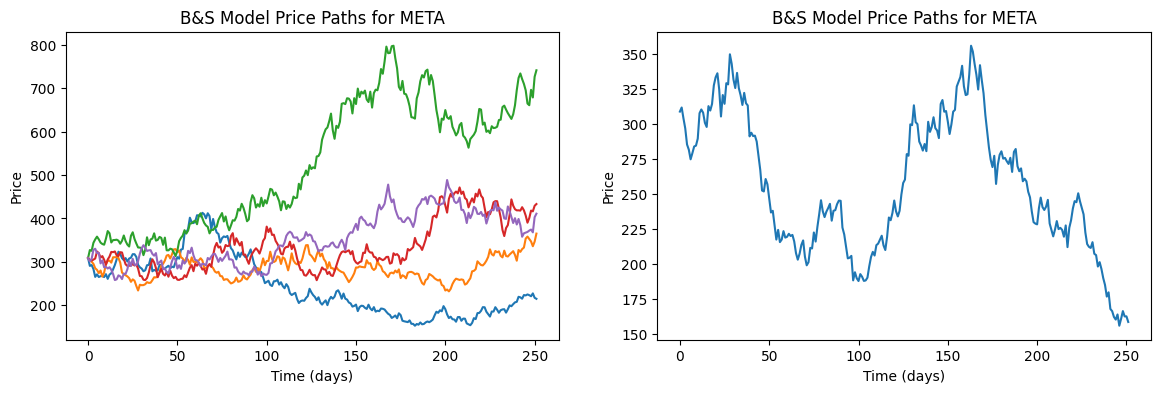

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [7]:
# Plot a subset of 5
subset = 5
SBS_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SBS_subset[path] = SBlackScholes[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
BS.plotBSPath(SBS_subset.T, symbol, ax =axes[0] )
BS.plotBSPath(SBlackScholes[:, np.random.choice(paths)], symbol, ax=axes[1])  # Plot only one
plt.show()

### Merton Jump Diffusion model

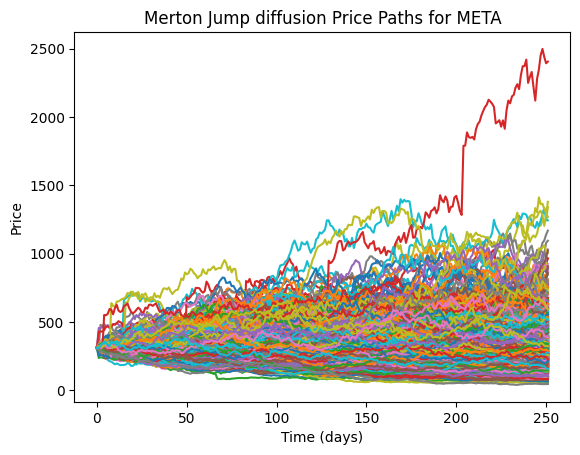

<Figure size 1000x600 with 0 Axes>

In [8]:
lamda = 0.5
jump_mean = 0
jump_std = 0.2
Merton = Merton_pricer(S0, K, T, r, q, sigma, lamda, jump_mean, jump_std, exercise)
SMerton = Merton.MertonPath(days, paths)
Merton.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Plot subsets of paths

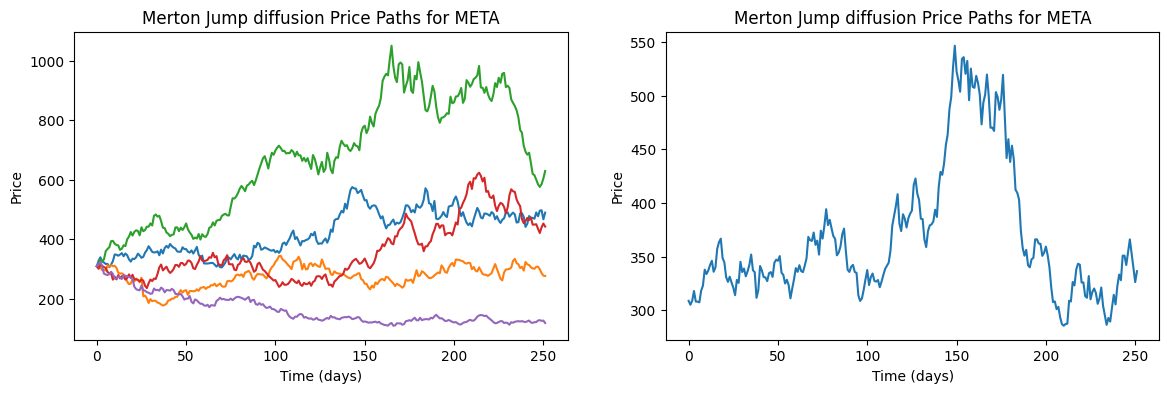

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [9]:
subset = 5  # Plot a subset of 5
SM_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SM_subset[path] = SMerton[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
Merton.plotMertonPath(SM_subset.T, symbol, ax=axes[0])
Merton.plotMertonPath(SMerton[:, np.random.choice(paths)], symbol, ax=axes[1])  # Plot only one
plt.show()

### Kou Jump Diffusion Model

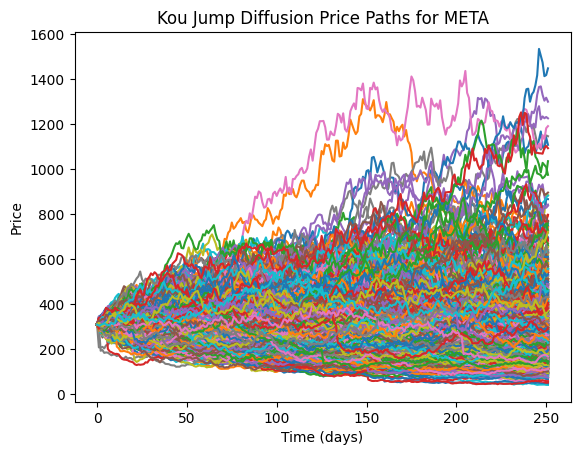

<Figure size 1000x600 with 0 Axes>

In [10]:
eta1 = 10  # upward jump magnitude
eta2 = 2  # downward jump
p = 0.4  # q = 0.6
KOU = Kou_pricer(S0, K, T, r, sigma, lamda, p, eta1, eta2, exercise)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

#### Plot subsets of paths

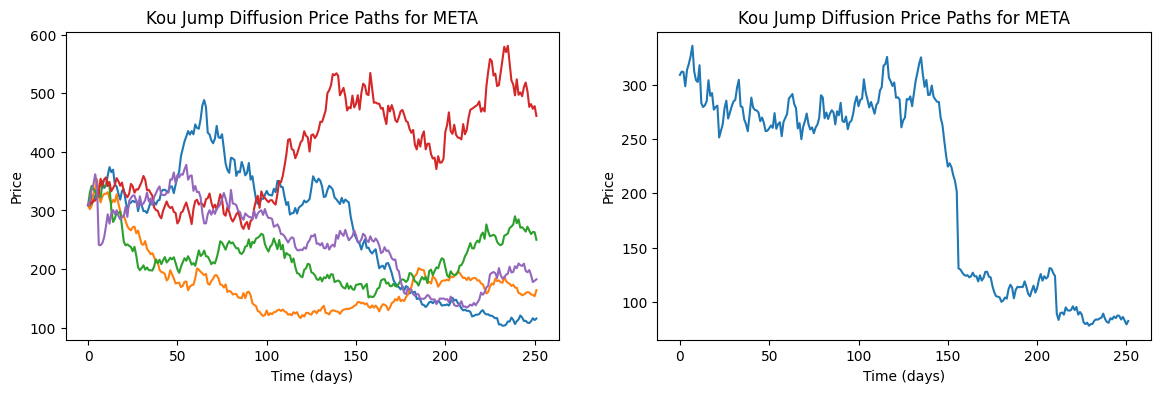

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [11]:
# Plot a subset of 5
subset = 5
SK_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SK_subset[path] = SKou[:, random_indices[path]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
KOU.plotKouPath(SK_subset.T, symbol, ax=axes[0])
KOU.plotKouPath(SKou[:, np.random.choice(paths)], symbol, ax=axes[1])
plt.show()

### Variance Gamma Model

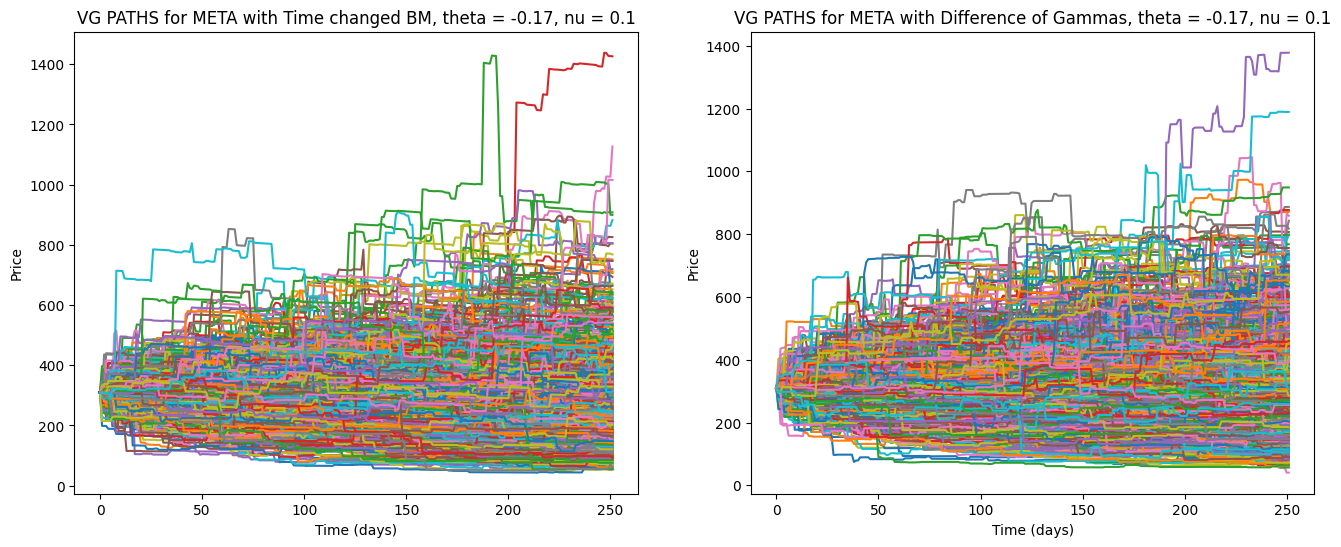

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [12]:
theta = -0.17
nu = 0.1
VG = VG_pricer(S0, K, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

#### Plot a subset of 5 paths

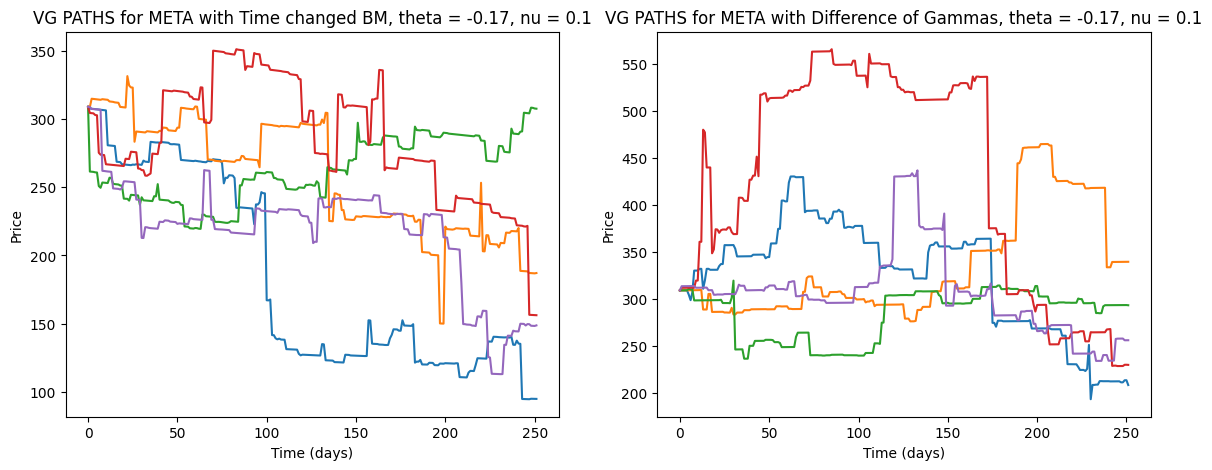

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [13]:
fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

subset = 5  # Plot a subset of 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma[:, random_indices[path]]
VG.plotVGPath(SVG_subset.T, symbol, method[0], ax=axes[0])

subset = 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma2[:, random_indices[path]]
VG.plotVGPath(SVG_subset.T, symbol, method[1], ax=axes[1])

#### Plot only one random path

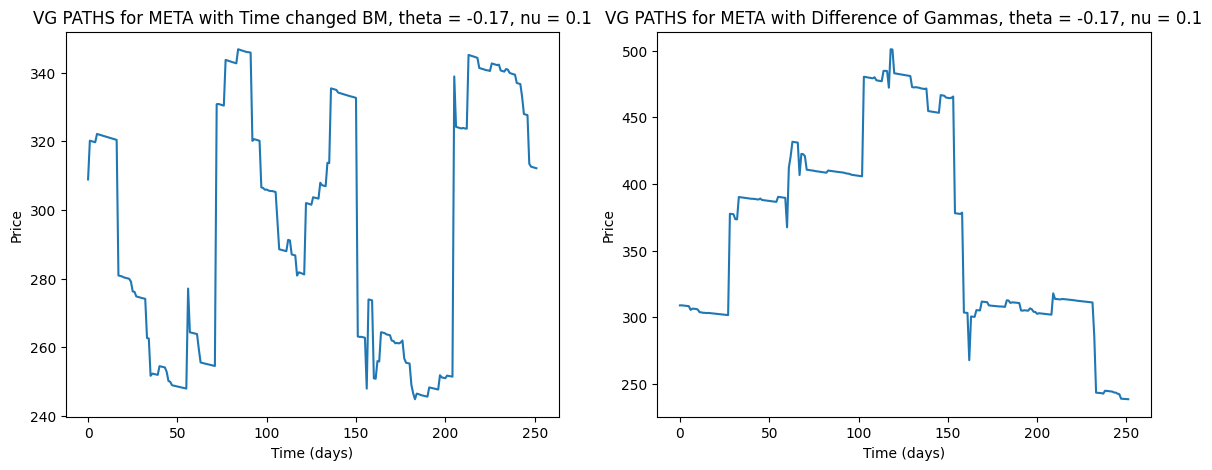

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [14]:
# Plot only one
fig3, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
VG.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[1], ax=axes[1])
plt.tight_layout()

#### From Seneta 2004, moments method

In [15]:
# Estimate params of VG (ref. Seneta 2004)
sigma_est = np.sqrt(VG.find_moment(2))
theta_est = sigma*(VG.find_moment(3))/(3*nu)
nu_est = (VG.find_moment(4)/3) - 1

print(f'Variance Gamma Estimated Params\n\t\tSTART\tEXT')
print(f'Sigma:  {round(sigma,2)} -> {round(sigma_est,4)}')
print(f'Theta: {theta} -> {round(theta_est,4)}')
print(f'Nu:     {nu} -> {round(nu_est,4)}')

Variance Gamma Estimated Params
		START	EXT
Sigma:  0.55 -> 0.1653
Theta: -0.17 -> -0.0025
Nu:     0.1 -> -0.9993


### Visualize distributions
#### Distribution of prices

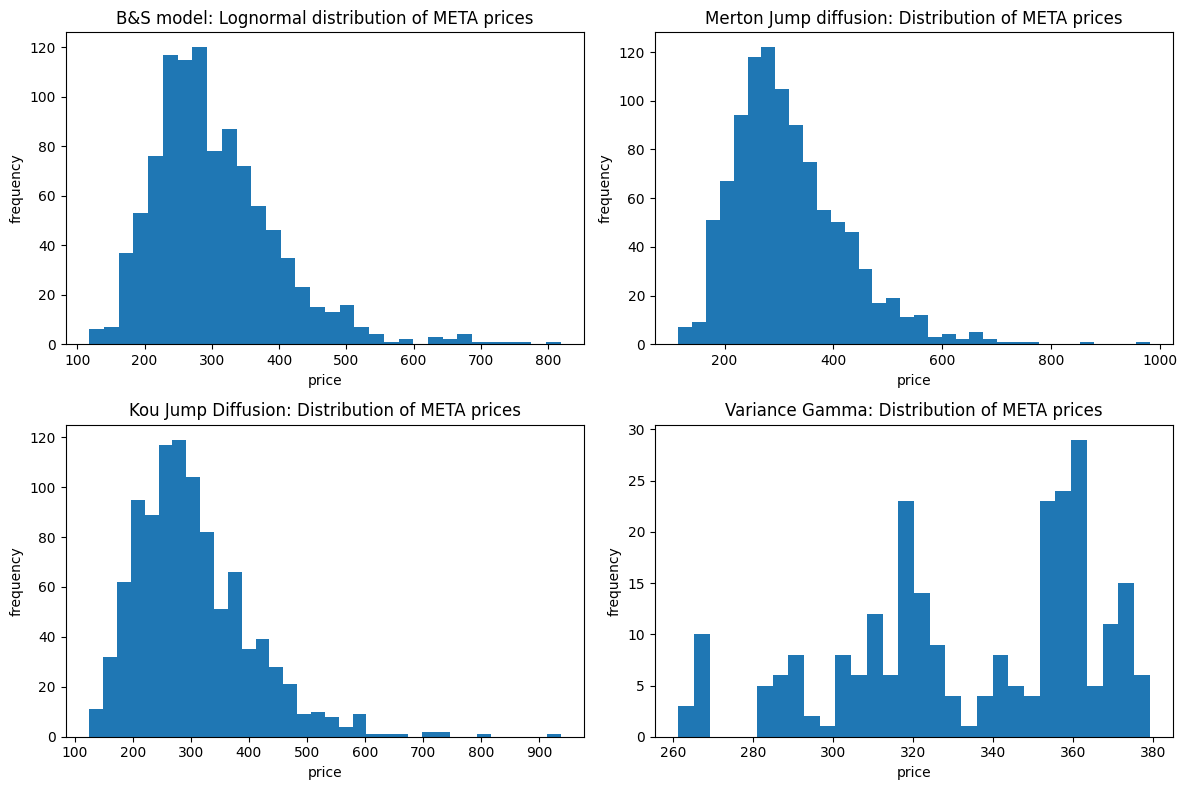

In [16]:
# %%%%%%%%%%%%%%%%%%%%%%%%    Visualize distributions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Average prices
fig4, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
BS.plotBSDist(SBlackScholes, symbol, ax = axes[0,0])
Merton.plotMertonDist(SMerton, symbol, ax = axes[0,1])
KOU.plotKouDist(SKou, symbol, ax = axes[1,0])
VG.plotVGDist(SVG_subset, symbol, ax = axes[1,1])
plt.tight_layout()
plt.show()

#### Cumulative distribution of Log returns

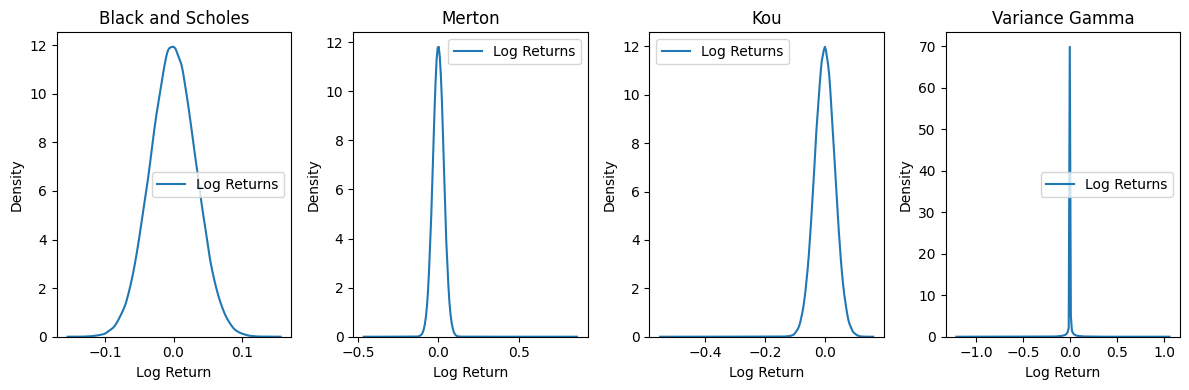

In [17]:
# Log returns ALL PATHS
fig5, axes5 = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
BS.plotBSLogReturns(SBlackScholes, symbol, ax=axes5[0])
Merton.plotMertonLogReturns(SMerton, symbol, ax=axes5[1])
KOU.plotKouLogReturns(SKou, symbol, ax=axes5[2])
VG.plotVGLogReturns(SVarGamma2, symbol, ax=axes5[3])
plt.tight_layout()

#### Distribution of Log Returns of a Sampled Path

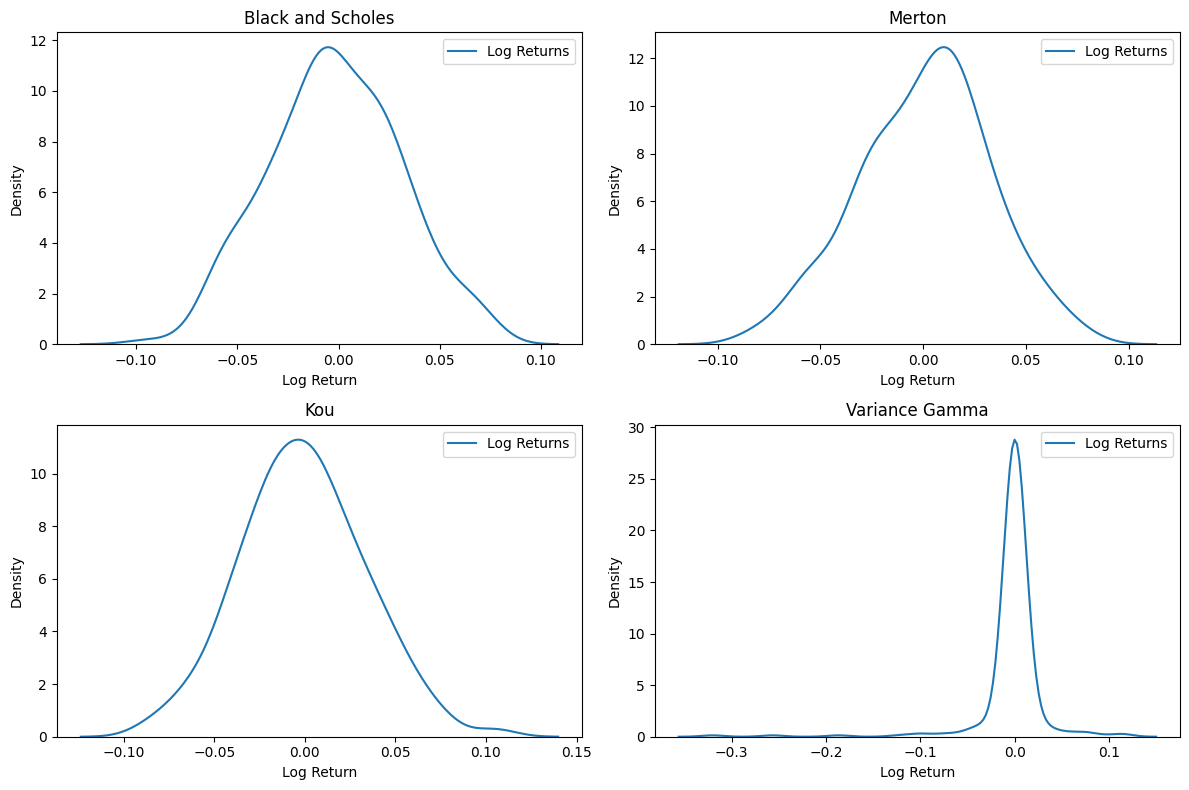

In [18]:
# Log returns ONE RANDOM
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
BS.plotBSLogReturns(SBlackScholes[:, np.random.choice(paths)], symbol, axes6[0,0])
Merton.plotMertonLogReturns(SMerton[:, np.random.choice(paths)], symbol, axes6[0,1])
KOU.plotKouLogReturns(SKou[:, np.random.choice(paths)], symbol, axes6[1,0])
VG.plotVGLogReturns(SVarGamma2[:, np.random.choice(paths)], symbol, axes6[1,1])
plt.tight_layout()


## Calibrated parameters
Before simulating paths with the calibrated parameters, let's retrieve the SP500 real data from Jan 2016 to Jan 2018. These data have been collected from [yahoo-finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC) and preprocessed in `StockAnalysis.ipynb`.

In [19]:
# SP500 real data
spx_data = pd.read_csv('data/sp500_data.csv')
print(spx_data.head())

         Date         Open         High          Low        Close      Volume   
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000  \
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000   
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000   
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000   
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000   

    Returns  Log Returns  Returns (%)  
0       NaN          NaN          NaN  
1  1.005195     0.005182     0.519544  
2  1.020284     0.020081     2.028370  
3  0.984362    -0.015762    -1.563798  
4  1.014144     0.014045     1.414434  


The model parameters have been calibrated on the SPX index on options starting on January 16, 2016. Now we can simulate paths using the just calibrated parameters for each model.

In [20]:
bs_sigma = 0.1491                                  # [σ]

#mert_params = [0.1141, 0.42, -0.22, 0.3394]
# mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
mert_params = [0.0878, 0.9085, -0.118, 0.0963]           # [σ, λ, m, v]

#kou_params = [0.21022, 0.04, 0.4, 0.0, 15.0]        # [σ, λ, p, η_1, η_2]
# kou_params = [0.0863, 2.2065, 0.0, 9.8519, 15.0]
kou_params = [0.07, 0.9296, 0.2498, 13.0534, 6.5574]

# vg_params= [0.14575, 0.11985, 0.41850]
vg_params = [0.2633, -0.1039, 0.0138]                   # [σ, θ, v]
#vg_params = [0.1259, 0.1921, 0.3751]

S0 = spx_data.loc[0, 'Close']
r = 0.0
T = 1
symbol = 'SPX'

#### Historical data from SPX Time Series (2016-2018)

In [21]:
# SPX value at 20/01/2016
SPX_S0 = spx_data.loc[spx_data['Date'] == '2016-01-20', 'Close'].values[0]

# SPX value after 252 days
SPX_St = spx_data.loc[spx_data['Date'] == '2017-01-18', 'Close'].values[0]

print(f'\nSPX value on the 20th Jan, 2016: {SPX_S0}')
print(f'SPX value after 252 days (on Jan 18, 2017): {SPX_St}')


SPX value on the 20th Jan, 2016: 1859.3299560546875
SPX value after 252 days (on Jan 18, 2017): 2271.889892578125


In [22]:
spx_data['Date'] = pd.to_datetime(spx_data['Date'])

# Historic volatility 1 year
start_date = pd.to_datetime('2016-01-20')
end_date_1y = pd.to_datetime('2017-01-20')

selected_data_1y = spx_data.loc[(spx_data['Date'] >= start_date) & (spx_data['Date'] <= end_date_1y), 'Close']
sp_vola_1y = selected_data_1y.pct_change().std() * np.sqrt(252)
print(f'Historical volatility (1 year): {round(sp_vola_1y, 4)}, {round(sp_vola_1y*100,3)}%')

# Historic volatility 2 years
end_date_2y = pd.to_datetime('2018-01-20')

selected_data_2y = spx_data.loc[(spx_data['Date'] >= start_date) & (spx_data['Date'] <= end_date_2y), 'Close']
sp_vola_2y = selected_data_2y.pct_change().std() * np.sqrt(252*2)
print(f'\nHistorical volatility (2 years): {round(sp_vola_2y, 4)}, {round(sp_vola_2y*100,3)}%')

Historical volatility (1 year): 0.1203, 12.031%

Historical volatility (2 years): 0.1382, 13.823%


#### Black and Scholes

(252, 1000)


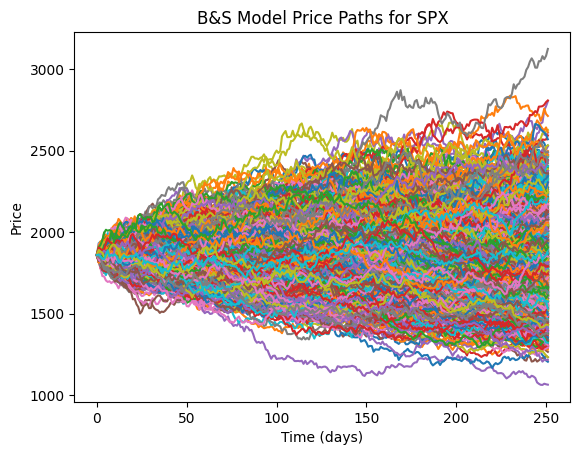

<Figure size 1000x600 with 0 Axes>

In [23]:
BS = BS_Pricer(S0, r, q, bs_sigma, T, exercise, K)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
print(SBlackScholes.shape)

In [24]:
symbol = 'META'  # AAPL, TSLA, MSFT, META, CAT, STM, GOOG, NFLX, AMZN
dates = options.get_expiration_dates(symbol)
# print(dates)

T_str = 'June 21, 2024'  # This is the first "greater than a year" expiry date
calls = options.get_calls(symbol, T_str)
puts = options.get_puts(symbol, T_str)

T_datetime = datetime.strptime(T_str, '%B %d, %Y')
ttm = (T_datetime - datetime.now()).days / 365.0  # to use the time to maturity in float mode

calls['Time-to-maturity'] = ttm
puts['Time-to-maturity'] = ttm
# display(calls.columns)
print(calls.head())

         Contract Name         Last Trade Date  Strike  Last Price     Bid   
0  META240621C00005000   2023-07-13 1:55PM EDT     5.0      310.36    0.00  \
1  META240621C00010000   2023-02-27 3:36PM EDT    10.0      160.70  194.00   
2  META240621C00015000   2023-07-12 2:50PM EDT    15.0      292.81    0.00   
3  META240621C00020000  2023-02-28 11:10AM EDT    20.0      157.30  187.85   
4  META240621C00025000   2023-06-15 9:30AM EDT    25.0      248.78  283.20   

      Ask  Change % Change Volume Open Interest Implied Volatility   
0    0.00     0.0        -     28             0              0.00%  \
1  197.90     0.0        -      4            11              0.00%   
2    0.00     0.0        -      2             0              0.00%   
3  189.75     0.0        -      2            26              0.00%   
4  286.30     0.0        -      2            96            131.98%   

   Time-to-maturity  
0          0.928767  
1          0.928767  
2          0.928767  
3          0.928767  


#### Merton Jump Diffusion

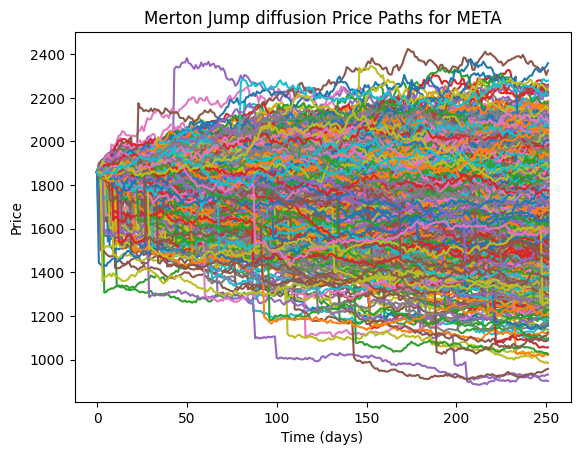

<Figure size 1000x600 with 0 Axes>

In [25]:
MERT = Merton_pricer(S0, K, T, r, q, mert_params[0], mert_params[1], mert_params[2], mert_params[3], exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Kou Jump Diffusion

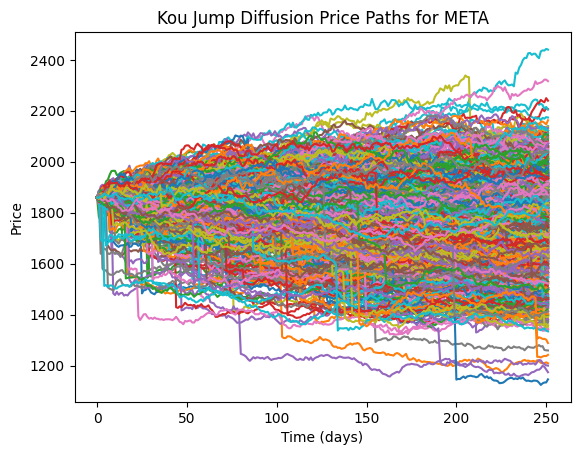

<Figure size 1000x600 with 0 Axes>

In [26]:
KOU = Kou_pricer(S0, K, ttm, r, kou_params[0], kou_params[1], kou_params[2], kou_params[3], kou_params[4], S0)
SKou = KOU.KouPath(days, paths)

# Plot all paths
KOU.plotKouPath(SKou, symbol)

#### Variance Gamma

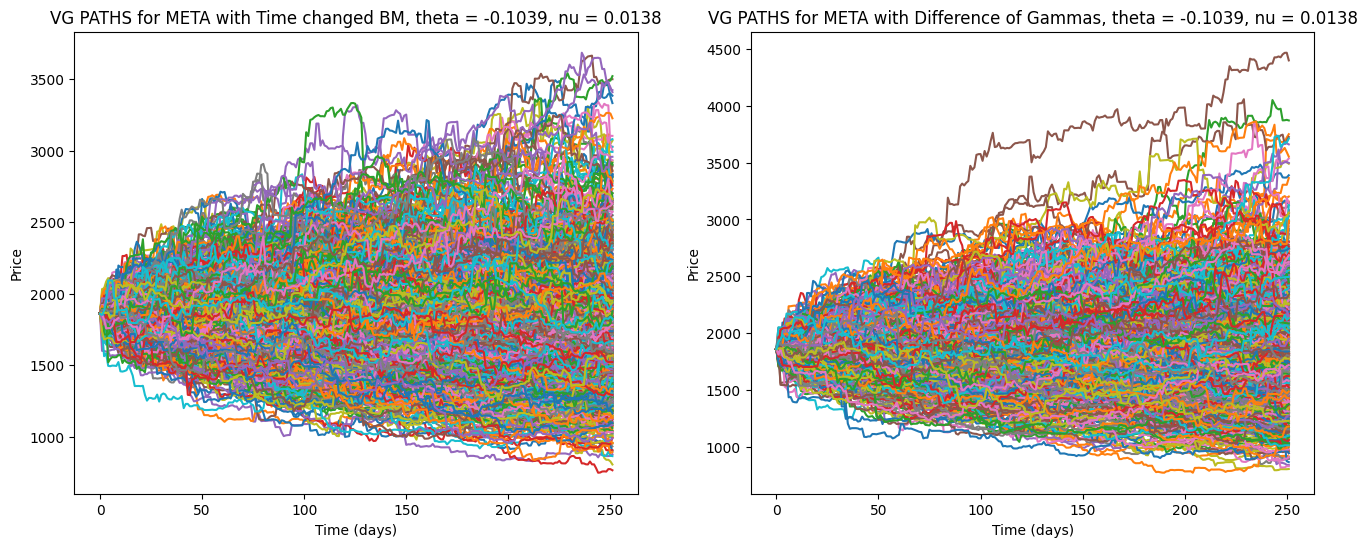

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [27]:
sigma = vg_params[0]
theta = vg_params[1]
nu = vg_params[2]

VG = VG_pricer(S0, K, T, r, q, sigma, theta, nu, exercise)
SVarGamma = VG.VarianceGammaPath1(days, paths)
SVarGamma2 = VG.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG.plotVGPath(SVarGamma, symbol, method[0], ax=axes[0])
VG.plotVGPath(SVarGamma2, symbol, method[1], ax=axes[1])
plt.tight_layout()

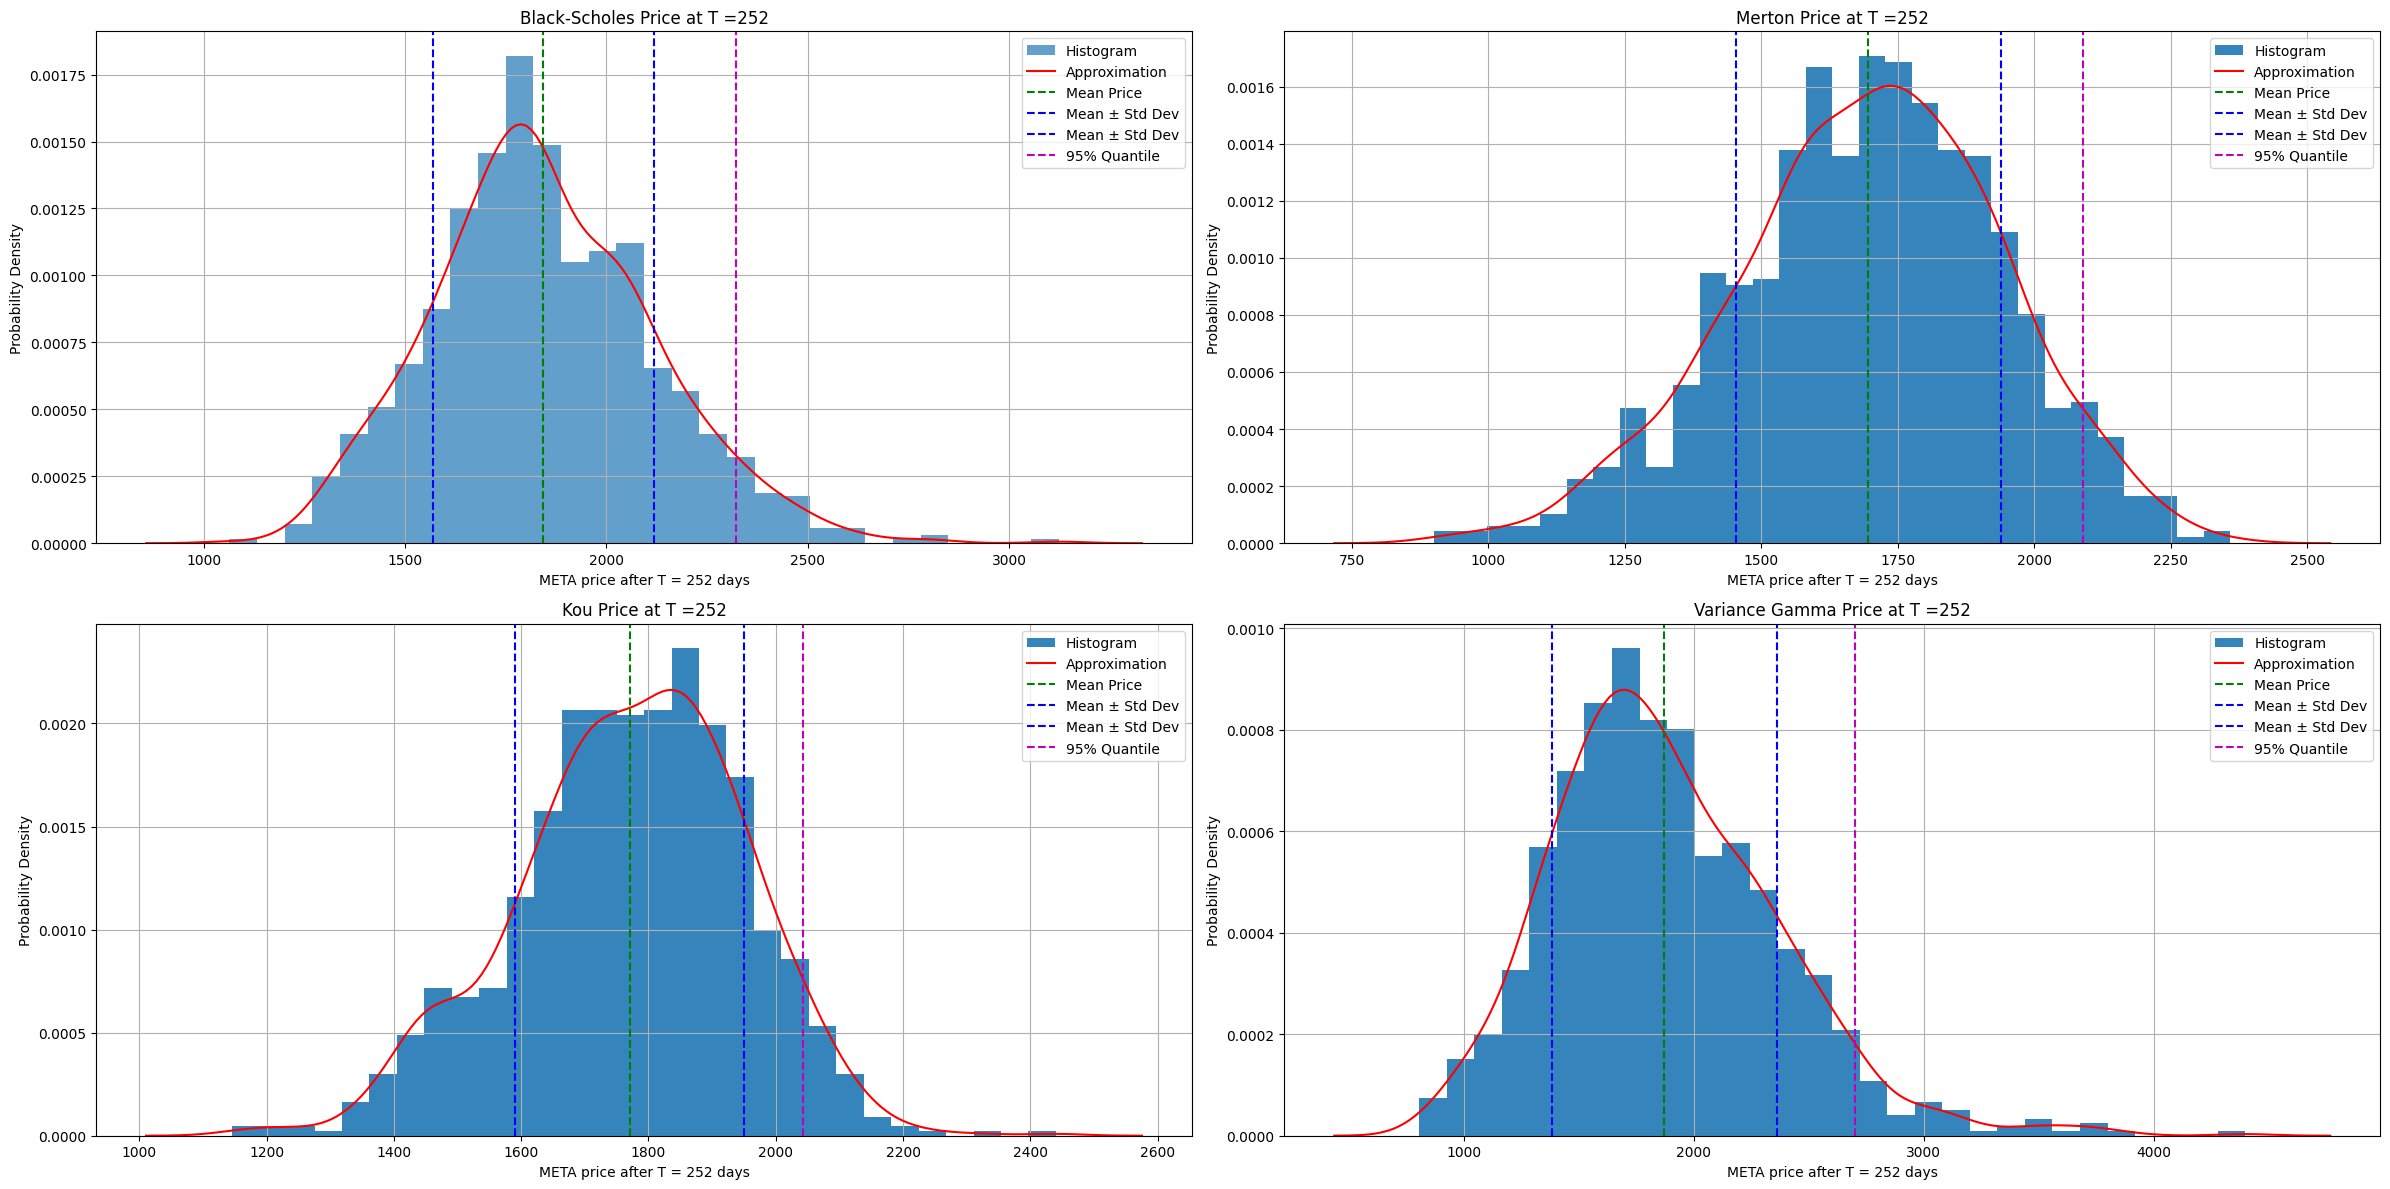

In [28]:
fig, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
BS.plotBSAtFixedTime(SBlackScholes, 251, symbol, ax = axes6[0,0])
MERT.plotMertonAtFixedTime(SMerton, 251, symbol, ax = axes6[0,1])
KOU.plotKouAtFixedTime(SKou, 251, symbol, ax = axes6[1,0])
VG.plotVGAtFixedTime(SVarGamma2, 251, symbol, ax = axes6[1,1])
plt.tight_layout()
plt.show()

Then we find the average value of the $N = 1000$ paths after $T=252$ days, i.e. one year later.

In [29]:
# Day-by-day mean of the 1000 paths, for each model
daily_avg = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou', 'VarGamma1', 'VarGamma2'])
#daily_avg['Days'] = np.linspace(0,251,1)

daily_avg['BlackScholes'] = SBlackScholes.mean(axis=1)
daily_avg['Merton'] = SMerton.mean(axis=1)
daily_avg['Kou'] = SKou.mean(axis=1)
daily_avg['VarGamma1'] = SVarGamma.mean(axis=1)
daily_avg['VarGamma2'] = SVarGamma2.mean(axis=1)

In [30]:
print(daily_avg.tail())

     BlackScholes       Merton          Kou    VarGamma1    VarGamma2
247   1844.553604  1697.638203  1772.677003  1790.839114  1869.294581
248   1843.949781  1697.410695  1772.145617  1790.201039  1869.638789
249   1844.569839  1696.521583  1770.653033  1790.623518  1870.076125
250   1843.714442  1696.589162  1770.517560  1789.407910  1870.546429
251   1843.619878  1695.849092  1770.489865  1789.334037  1871.285503


In [31]:
fig1 = go.Figure()
for column in daily_avg.columns:
    fig1.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=daily_avg[column], name=column))

# Update the layout
fig1.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig1)

### MERTON DRIFT!!!
### CAPIRE KOU e VG come aggiustare drift

In [32]:
# Create a new figure
fig = go.Figure()

# Add trace for the real data
fig.add_trace(go.Scatter(x=spx_data.loc[0:251, 'Date'], y=spx_data.loc[0:251, 'Close'], name='Real Data'))

# Iterate over the simulated models and add traces for each model
for column in daily_avg.columns[:4]:
    fig.add_trace(go.Scatter(x=spx_data.loc[:, 'Date'], y=daily_avg[column], name=column))

# Update the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title = 'Real vs Simulated SPX paths',
    showlegend=True
)

# Show the plot
pio.show(fig)

### Monte Carlo simulation analysis

#### Volatility comparison of the Monte Carlo simulations

In [33]:
window_length = 1      #daily trading

# Log returns of all the Monte Carlo paths
log_returns_BS = np.log(SBlackScholes[1:] / SBlackScholes[:-1])
log_returns_MERT = np.log(SMerton[1:] / SMerton[:-1])
log_returns_KOU = np.log(SKou[1:] / SKou[:-1])
log_returns_VG = np.log(SVarGamma[1:] / SVarGamma[:-1])

realized_volatilities = [np.std(log_returns_BS[-window_length:]) * np.sqrt(252), np.std(log_returns_MERT[-window_length:]) * np.sqrt(252), np.std(log_returns_KOU[-window_length:]) * np.sqrt(252), np.std(log_returns_VG[-window_length:]) * np.sqrt(252)]


print("Realized volatilities per model:", realized_volatilities)


Realized volatilities per model: [0.14945422924449234, 0.1706547234253777, 0.1136117393281029, 0.24187553238882092]


In [34]:
data = {
    'Historical': [sp_vola_1y]*4,
    'Implied': [bs_sigma, mert_params[0], kou_params[0], vg_params[0]],
    'Realized (MC paths)': realized_volatilities
}

volas = pd.DataFrame(data, index=['BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])

print('VOLATILITY COMPARISON: \n', volas)

#vg
# realized modelli di salto: depurare dai salti e calcolare quello che resta
# verificare realized vola

VOLATILITY COMPARISON: 
                Historical  Implied  Realized (MC paths)
BlackScholes     0.120312   0.1491             0.149454
Merton           0.120312   0.0878             0.170655
Kou              0.120312   0.0700             0.113612
VarianceGamma    0.120312   0.2633             0.241876


#### Jump Analysis of the Monte Carlo simulations

In [36]:
# How many Jumps in SPX data, according to estimate parameters

# MERTON MODEL
print(f'MERTON MODEL:\n>Average Jump intensity = {mert_params[2]}')
print(f'> Standard Deviation = {mert_params[3]}')
print(f'> Rate of jumps (num per year) λ = {mert_params[1]}')

jump = (mert_params[2] + mert_params[3])
jump_return = 1 - abs(jump)
print(jump_return)

MERTON MODEL:
>Average Jump intensity = -0.118
> Standard Deviation = 0.0963
> Rate of jumps (num per year) λ = 0.9085
0.9783


In [37]:
spx_jumps_real = spx_data[spx_data['Returns'] < jump_return].copy()
print(spx_jumps_real)

          Date         Open         High          Low        Close   
109 2016-06-24  2103.810059  2103.810059  2032.569946  2037.410034  \
162 2016-09-09  2169.080078  2169.080078  2127.810059  2127.810059   

         Volume   Returns  Log Returns  Returns (%)  
109  7597450000  0.964080    -0.036581    -3.591980  
162  4233960000  0.975478    -0.024828    -2.452207  


In [38]:
highlight_dates = spx_jumps_real['Date'].tolist()

start_date = datetime(2016, 1, 20)
end_date = datetime(2017, 1, 20)

# Create the figure
fig = go.Figure()

# Add STOCK data to the figure
fig.add_trace(go.Scatter(x=spx_data['Date'].values, y=spx_data['Close'], name=symbol))

# Set the layout with the secondary y-axis
fig.update_layout(
    title=f'Highlight SPX jumps according to Merton model',
    xaxis_title='Date',
    yaxis=dict(
        title='SPX value',
        anchor='free',
        side='left',
        position=0.05
    ),
)


# Highlight the specific days
for date in highlight_dates:
    close_value = spx_data.loc[spx_data['Date'] == date, 'Close'].values[0]
    jump_size = spx_jumps_real.loc[spx_jumps_real['Date'] == date, 'Returns'].values[0]
    fig.add_annotation(
        x=date, y=close_value,
        text=f'Jump Size: {round(jump_size,4)}',
        showarrow=True,
        arrowhead=1,
        arrowsize=1.5,
        arrowwidth=2,
        arrowcolor='red',
        ax=20,
        ay=-40,
        xanchor='center',
        font=dict(color='red')
    )

# Display the figure
fig.show()